In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings  # Supress warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
np.random.seed(7)

In [10]:
base = '../Informer2020-main-1.0/results/informer_custom_ftS_dm2048_dtt_q_500pa_ieTrue_sl8_ll4_pl8_lg0_dm2048_nh8_el2_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_0/'
real_pred = np.load('{}/real_prediction.npy'.format(base))
metric = np.load('{}/metrics.npy'.format(base))
scale = 32
metric

array([1.2369847, 2.5644827, 1.6014003,       inf,       inf],
      dtype=float32)

In [11]:
real_pred = real_pred.squeeze()
real_pred = real_pred[::8]
real_pred = real_pred.reshape(real_pred.shape[0]*real_pred.shape[1],1).squeeze()

In [12]:
real_true = pd.read_csv('../Informer2020-main-1.0/data/tem_pre/valid_station_22012802_22043023.csv')['tem'].values
real_true = real_true[scale:]

In [13]:
real_true.shape

(712,)

In [14]:
df = pd.DataFrame(columns = ['real_pred','real_true'])
df.real_pred = real_pred
df.real_true = real_true
df['bias'] = np.abs(df.real_true-df.real_pred)

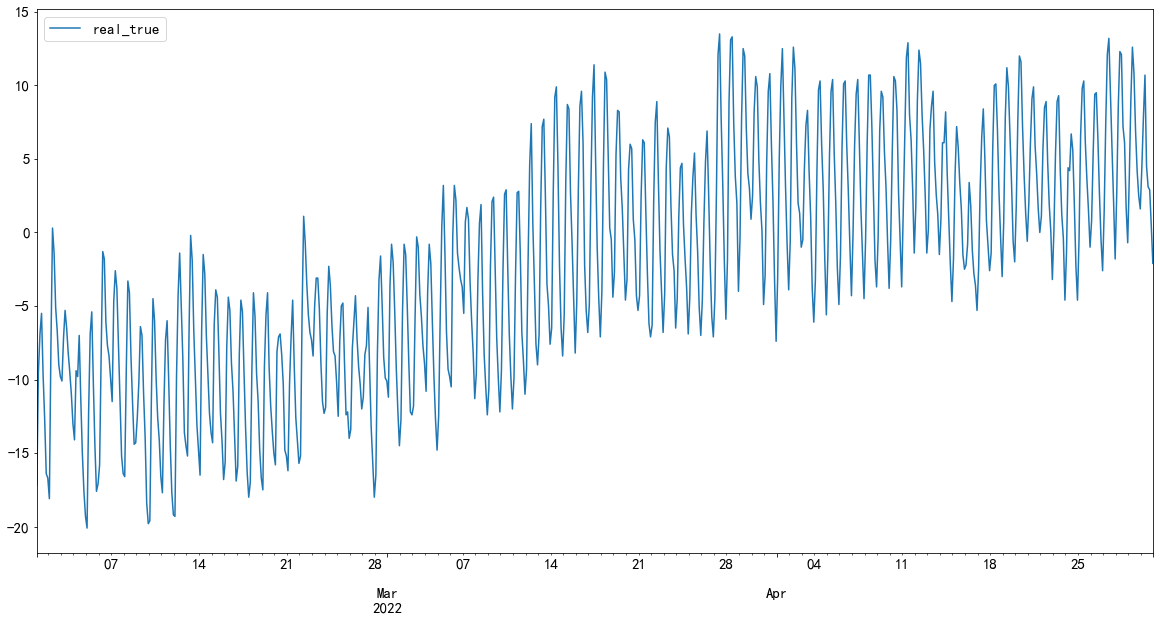

In [15]:
dates = pd.date_range(start="2022-02-01 02:00:00 ", end="2022-04-30 23:00:00",freq='3h')

df = df.set_index(dates)

df[['real_true']].plot(figsize=(20,10),fontsize=15)
# df[['real_pred','real_true']].plot(figsize=(20,10),fontsize=15)
plt.legend(loc = 0, prop = {'size':15})


# df['real_true'].plot(figsize=(20,10),kind='line')

In [16]:
np.mean(np.abs(real_true[:]-real_pred[:]))

1.3283611980047119

In [17]:
np.mean((real_true[:]-real_pred[:])**2)

3.0032159657252038

In [18]:
df['date'] = df.index

In [19]:
def point_scatter(df,true,pred):
    corr = np.corrcoef(df[true],df[pred])[0,1]
    ax = df.plot(x=true,y=pred,kind='scatter',figsize=(20,10),fontsize=15,c='blue')
    ax.set_xlabel(true,fontsize=20)
    ax.set_ylabel(pred,fontsize=20)
    # bbox = dict(boxstyle="round", fc='1',alpha=0.5)
    plt.text(0.05, 0.9, '$R^2=%.3f$' % (corr**2), 
             transform=ax.transAxes, size=25)
    ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k',label="1:1 line")


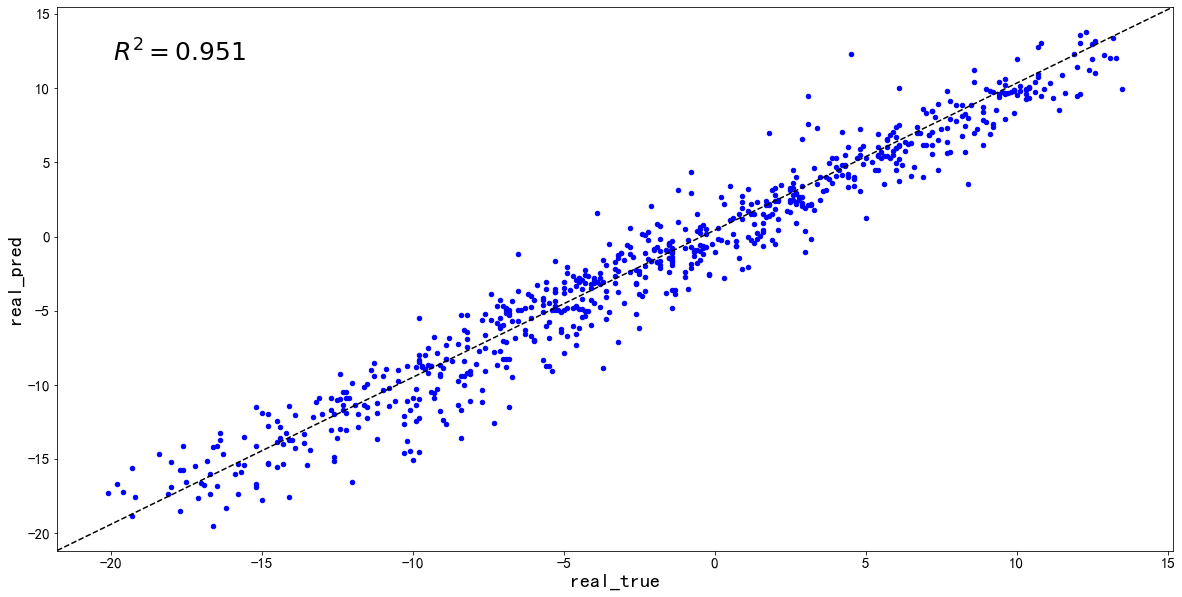

In [20]:
point_scatter(df,'real_true','real_pred')

In [21]:
# df.plot(x='date',y='bias',kind='scatter',figsize=(20,10))

In [22]:
def point_bar(bias):  
    bias.describe(percentiles=[.2,.4,.6,.8,.9])
    sections = [0,2,4,6,8,10]
    group_names = ['0-2','2-4','4-6','6-8','8-10']
    cuts = pd.cut(bias,sections,labels=group_names)
    counts = pd.value_counts(cuts)
    print(counts.shape)
    counts = counts/len(bias)
    ax = counts.plot(kind='bar',figsize=(20,10),title='误差分布直方图',fontsize=15)
    ax.axes.title.set_size(20)
    plt.text(0.7, 0.6, '%s' % (counts), 
             transform=ax.transAxes, size=25)

(5,)


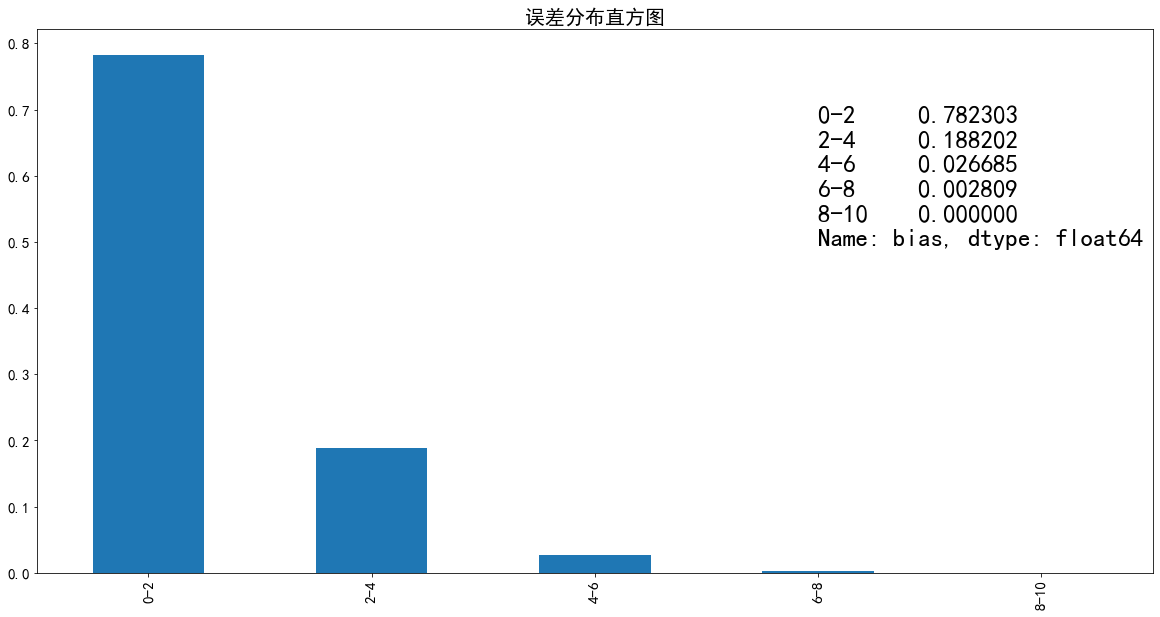

In [23]:
point_bar(df.bias)

## 最大值调整

In [24]:
df['date'] = pd.to_datetime(df['date']).apply(lambda x:x.strftime("%Y-%m-%d"))
df = df.reset_index()
## 最大值的方差在真实值里统计
real_true = df.real_true.values

### 段方差

In [25]:

std_true_past_3 = []
for i in range(0,712,1):
    j = i-3
    if j >= 0:
        std_true_past_3.append(np.std(real_true[j:i]))
    else:
        std_true_past_3.append(0)
df_max_tem = df.copy()
df_max_tem['std_true_past_3'] = std_true_past_3
df_max = df_max_tem.iloc[df.groupby(['date']).apply(lambda x: x['real_true'].idxmax())]

### 段方差相关性

,bias,std_true_past_3
bias,1.000000,0.121432
std_true_past_3,0.121432,1.000000


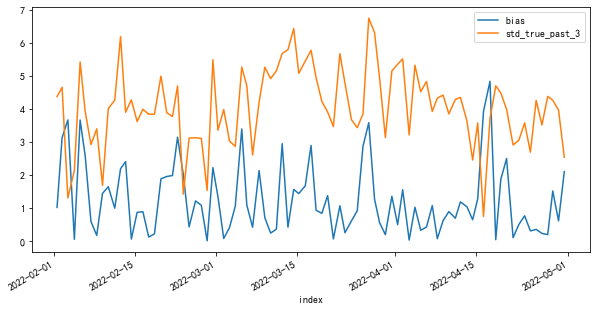

In [26]:
df_max.set_index('index')[['bias','std_true_past_3']].plot(figsize=(10,5))
df_max[['bias','std_true_past_3']].corr()

### 瞬时相位同步测量相关性

In [27]:

from scipy.signal import hilbert, butter, filtfilt
from scipy.fftpack import fft,fftfreq,rfft,irfft,ifft
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y
def point_Instantaneous(df,a,b):
    lowcut  = .01
    highcut = .5
    fs = 2.
    order = 1
    # d1 = df['S1_Joy'].interpolate().values
    # d2 = df['S2_Joy'].interpolate().values
    y1 = butter_bandpass_filter(df[a],lowcut=lowcut,highcut=highcut,fs=fs,order=order)
    y2 = butter_bandpass_filter(df[b],lowcut=lowcut,highcut=highcut,fs=fs,order=order)

    al1 = np.angle(hilbert(y1),deg=False)
    al2 = np.angle(hilbert(y2),deg=False)
    phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)
    N = len(al1)

    # 绘制结果
    f,ax = plt.subplots(3,1,figsize=(14,7),sharex=True)
    ax[0].plot(y1,color='r',label='y1')
    ax[0].plot(y2,color='b',label='y2')
    ax[0].legend(bbox_to_anchor=(0., 1.02, 1., .102),ncol=2)
    ax[0].set(xlim=[0,N], title='Filtered Timeseries Data')
    ax[1].plot(al1,color='r')
    ax[1].plot(al2,color='b')
    ax[1].set(ylabel='Angle',title='Angle at each Timepoint',xlim=[0,N])
    phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)
    ax[2].plot(phase_synchrony)
    ax[2].set(ylim=[0,1.1],xlim=[0,N],title='Instantaneous Phase Synchrony',xlabel='Time',ylabel='Phase Synchrony')
    plt.tight_layout()
    plt.show()

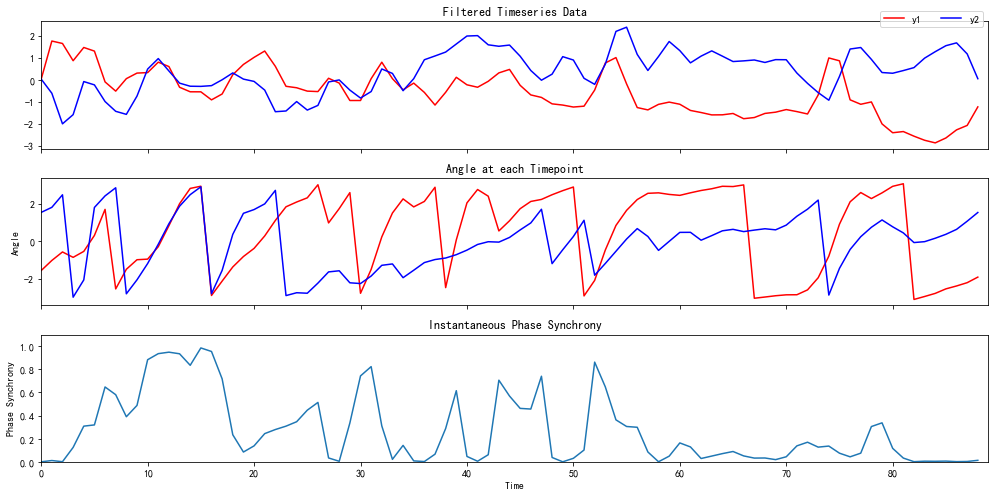

In [28]:
point_Instantaneous(df_max,'bias','std_true_past_3')

###  最大值调整前

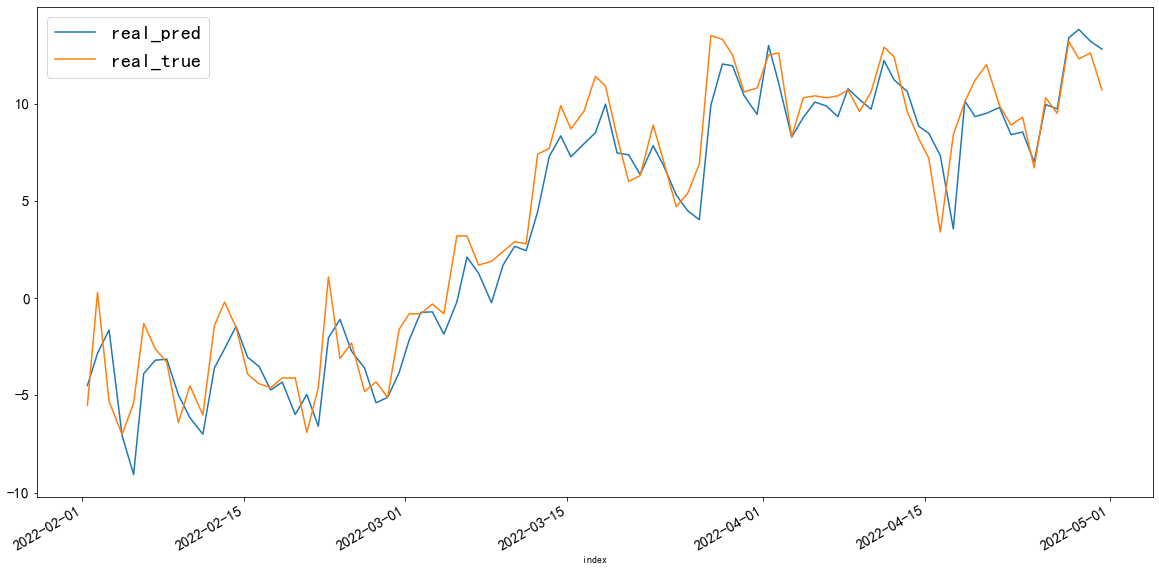

In [29]:
df_max  = df_max.set_index('index')
df_max[['real_pred','real_true']].plot(figsize=(20,10),fontsize=15)
np.mean(np.abs(df_max['real_pred']-df_max['real_true']))
plt.legend(loc = 0, prop = {'size':20})

### 最大值调整后

1.0789195371572076

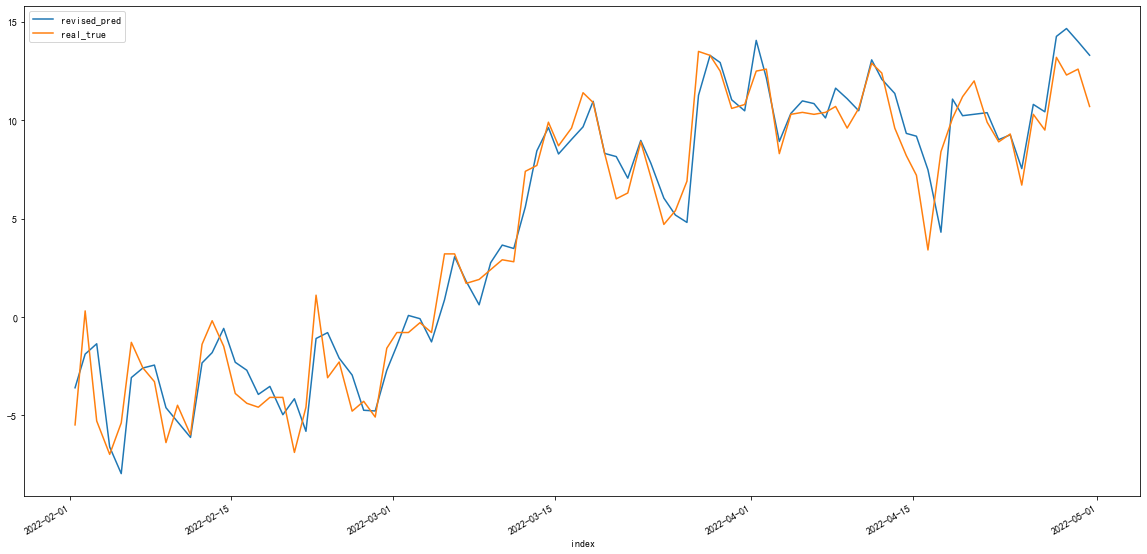

In [30]:

df_max['revised_pred'] = df_max['real_pred']+df_max['std_true_past_3']*0.2
df_max[['revised_pred','real_true']].plot(figsize=(20,10))
np.mean(np.abs( df_max['revised_pred']-df_max['real_true']))

## 最小值调整

In [31]:
df_min_tem = df.copy()

### 段方差

In [32]:
real_pred = df.real_pred.values
std_pred_past_3= []
for i in range(0,712,1):
    j = i-3
    if j >= 0:
        std_pred_past_3.append(np.std(real_pred[j:i]))
    else:
        std_pred_past_3.append(0)
   

df_min_tem['std_pred_past_3'] = std_pred_past_3
df_min = df_min_tem.iloc[df_min_tem.groupby(['date']).apply(lambda x: x['real_true'].idxmin())]

### 段方差相关性

,bias,std_pred_past_3
bias,1.000000,0.199317
std_pred_past_3,0.199317,1.000000


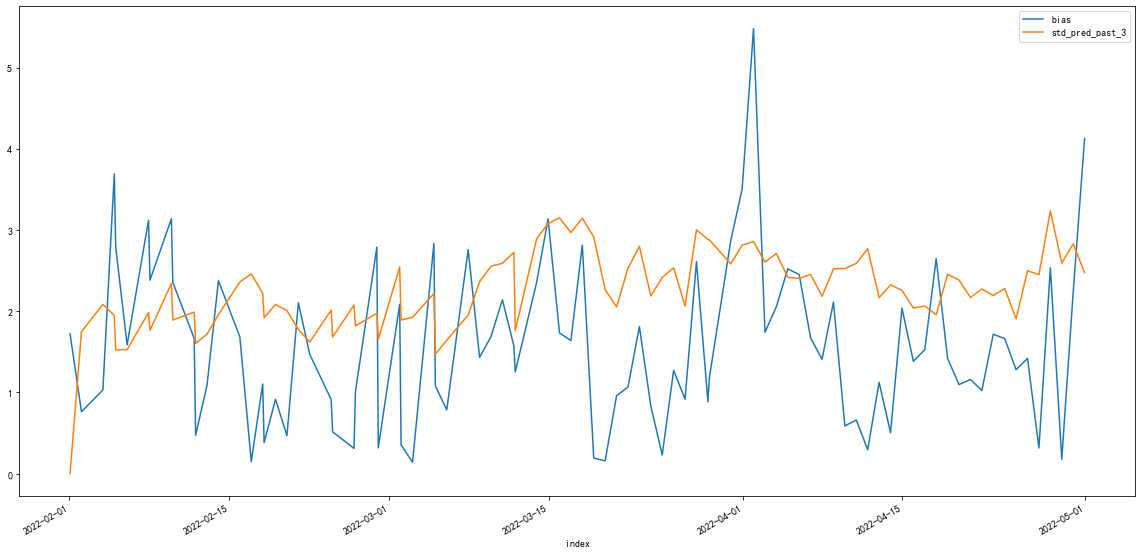

In [33]:

df_min.set_index('index')[['bias','std_pred_past_3']].plot(figsize=(20,10))
df_min[['bias','std_pred_past_3']].corr()

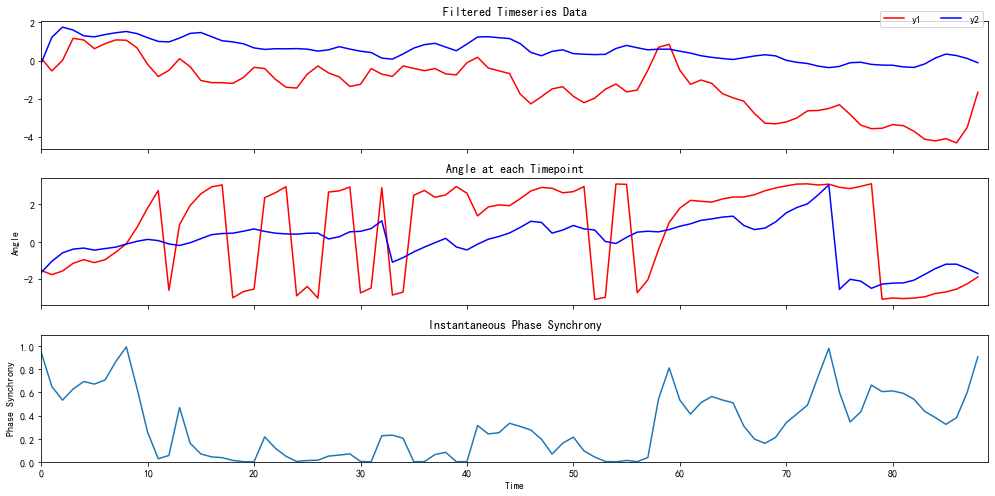

In [34]:
point_Instantaneous(df_min,'bias','std_pred_past_3')

### 最小值调整前

1.5846888440378595

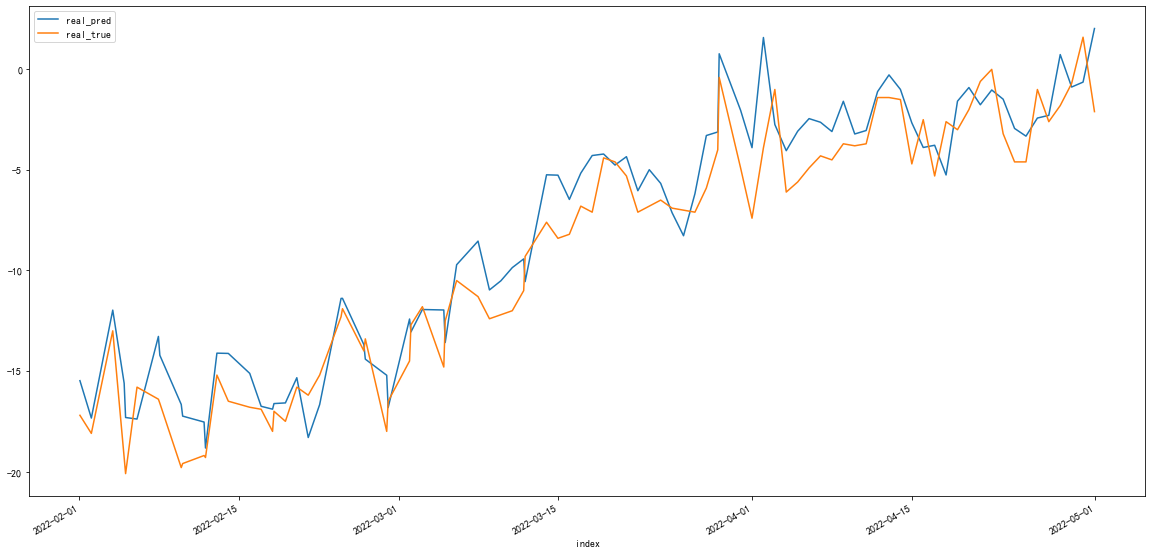

In [35]:
df_min.set_index('index')[['real_pred','real_true']].plot(figsize=(20,10))
np.mean(np.abs(df_min['real_pred']-df_min['real_true']))


### 最小值调整后

1.16397054503473

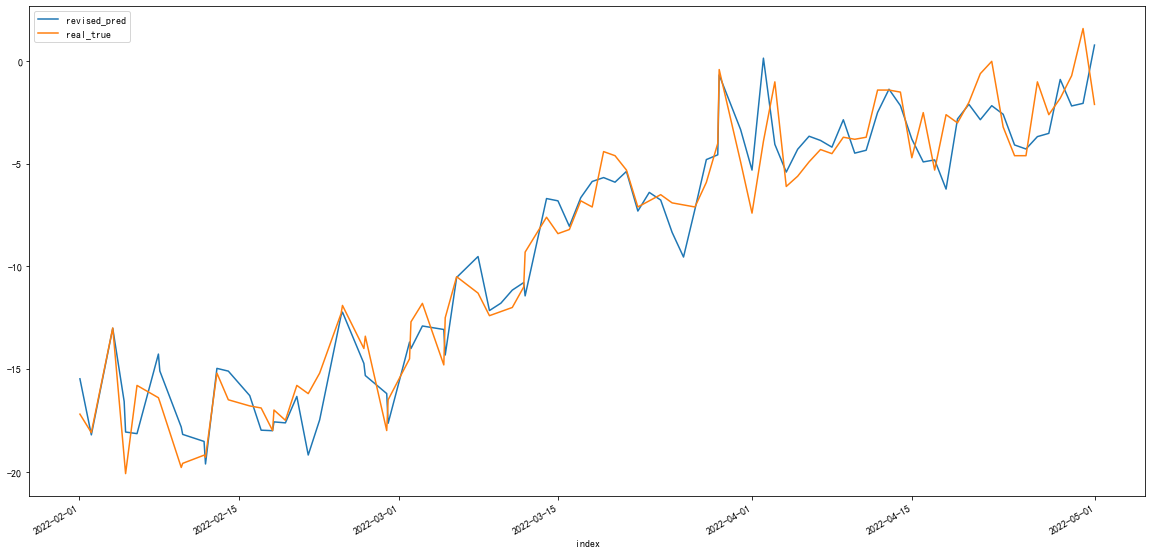

In [36]:
df_min['revised_pred'] = df_min['real_pred']-df_min['std_pred_past_3']*0.5
df_min.set_index('index')[['revised_pred','real_true']].plot(figsize=(20,10))
np.mean(np.abs(df_min['revised_pred']-df_min['real_true']))

## 将调整后的最值合并

In [37]:
df_max_join = df_max[['index','revised_pred']] 
df_max_join.rename(columns={'revised_pred':'real_pred'},inplace=True)
df_max_join = df_max_join.set_index('index')
df_min_join = df_min[['index','revised_pred']] 
df_min_join.rename(columns={'revised_pred':'real_pred'},inplace=True)
df_min_join = df_min_join.set_index('index')

KeyError: "['index'] not in index"

In [ ]:
df_revised  = df.copy()

In [ ]:
df_revised = df.set_index('index')

In [38]:
df_revised['tem']  = real_pred

NameError: name 'df_revised' is not defined

In [39]:
df_revised.update(df_max_join)

NameError: name 'df_revised' is not defined

In [49]:
df_revised.update(df_min_join)

In [50]:
df_revised

,real_pred,real_true,bias,date,tem
index,,,,,
2022-02-01 02:00:00,-15.477987,-17.2,1.722013,2022-02-01,-15.477987
2022-02-01 05:00:00,-8.687071,-9.5,0.812929,2022-02-01,-8.687071
2022-02-01 08:00:00,-4.817895,-6.9,2.082105,2022-02-01,-4.817895
2022-02-01 11:00:00,-3.611525,-5.5,1.013794,2022-02-01,-4.486206
2022-02-01 14:00:00,-8.778774,-9.7,0.921226,2022-02-01,-8.778774
...,...,...,...,...,...
2022-04-30 11:00:00,12.272632,4.5,7.772632,2022-04-30,12.272632
2022-04-30 14:00:00,9.443174,3.1,6.343174,2022-04-30,9.443174
2022-04-30 17:00:00,6.551485,2.9,3.651485,2022-04-30,6.551485


In [51]:
df_revised.columns=['revised_pred','real_true','revised_bias','date','real_pred']
df_revised['revised_bias'] = np.abs(df_revised['revised_pred'] - df_revised['real_true'])
df_revised['bias'] = np.abs(df_revised['real_pred'] - df_revised['real_true'])
df_revised.head()

,revised_pred,real_true,revised_bias,date,real_pred,bias
index,,,,,,
2022-02-01 02:00:00,-15.477987,-17.2,1.722013,2022-02-01,-15.477987,1.722013
2022-02-01 05:00:00,-8.687071,-9.5,0.812929,2022-02-01,-8.687071,0.812929
2022-02-01 08:00:00,-4.817895,-6.9,2.082105,2022-02-01,-4.817895,2.082105
2022-02-01 11:00:00,-3.611525,-5.5,1.888475,2022-02-01,-4.486206,1.013794
2022-02-01 14:00:00,-8.778774,-9.7,0.921226,2022-02-01,-8.778774,0.921226


### 预测值修正前后对比

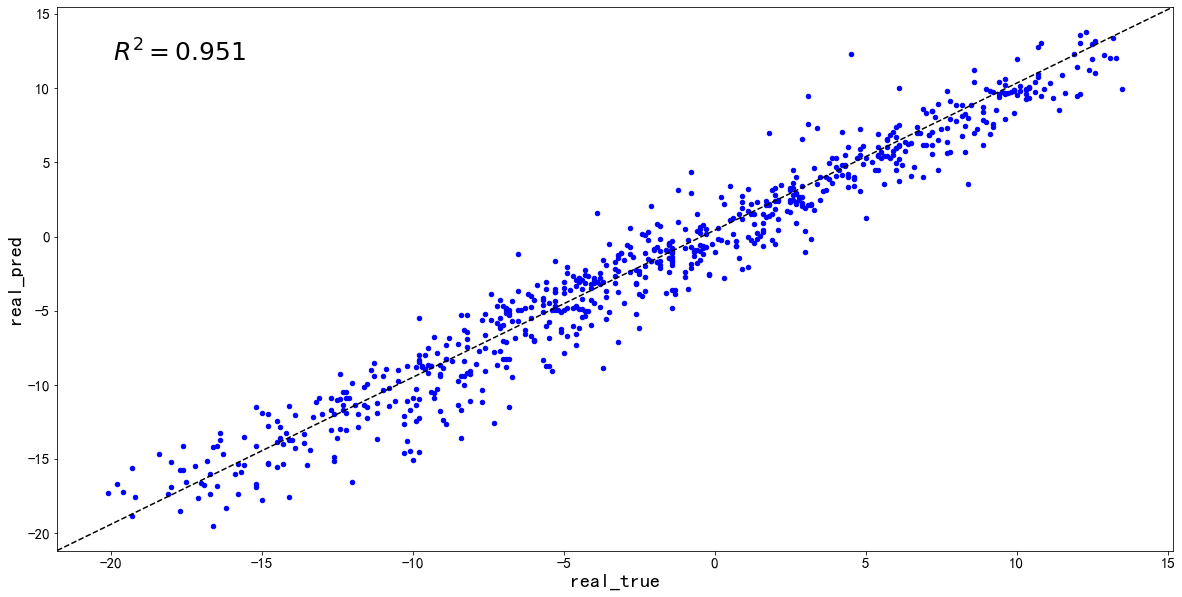

In [52]:
point_scatter(df_revised,'real_true','real_pred')

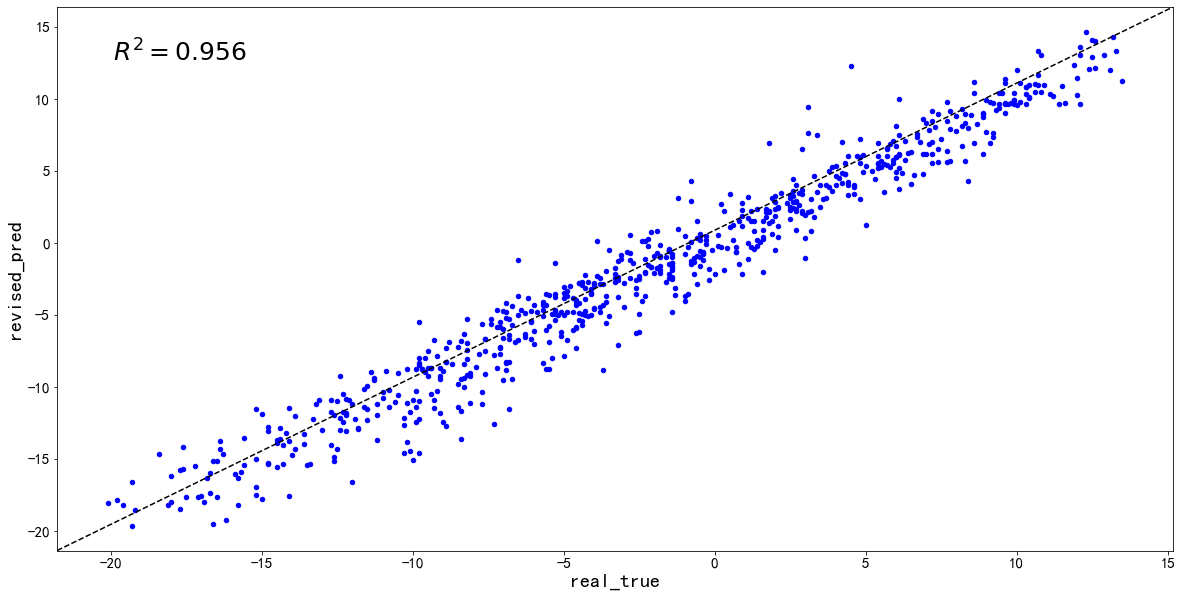

In [53]:
point_scatter(df_revised,'real_true','revised_pred')

In [73]:
df_revised.shape

(712, 6)

1.3283611980047119
1.2554069982330183


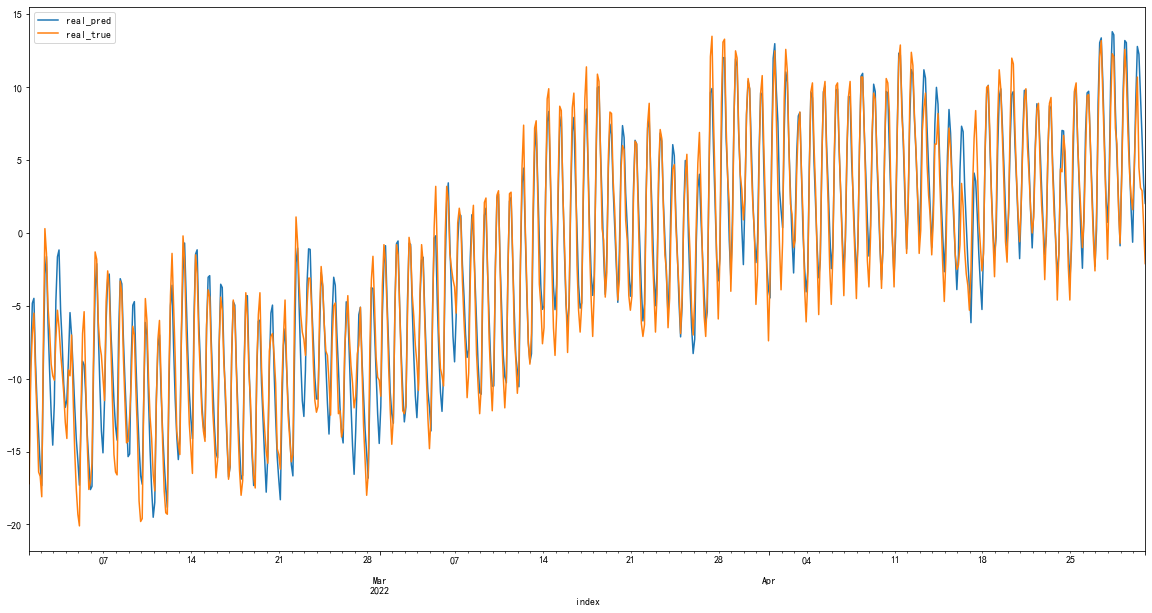

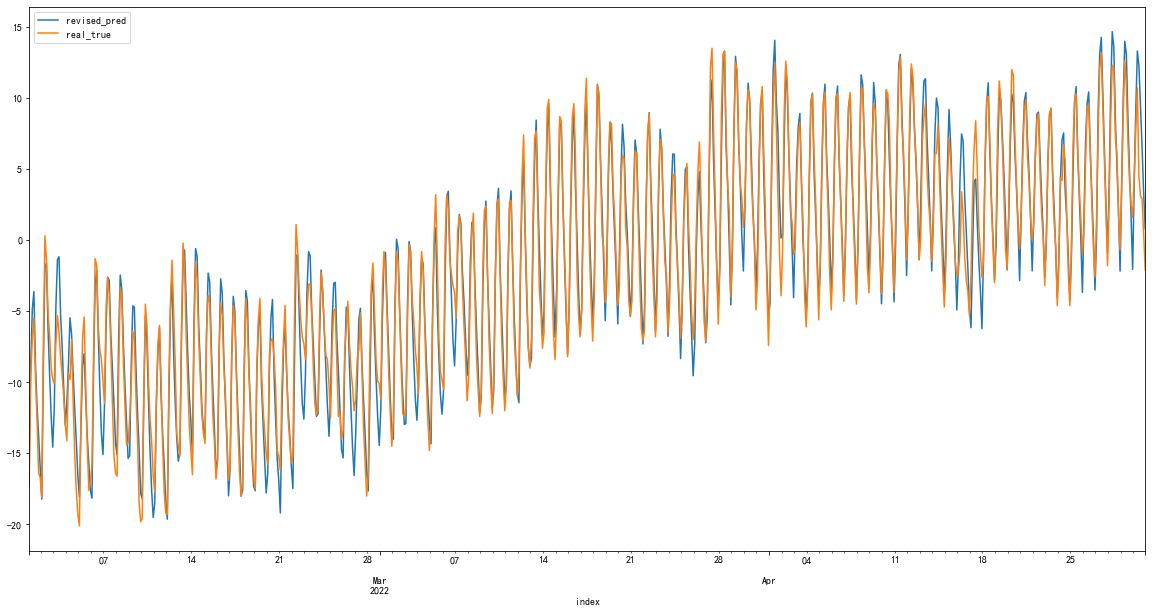

In [74]:
scale = [0,712]

print(np.mean(np.abs(df_revised['real_pred']-df_revised['real_true'])))
df_revised[['real_pred','real_true']][scale[0]:scale[1]].plot(figsize=(20,10))
df_revised[['revised_pred','real_true']][scale[0]:scale[1]].plot(figsize=(20,10))
print(np.mean(np.abs(df_revised['revised_pred']-df_revised['real_true'])))

{'0~2': 0.7823033707865169, '2~4': 0.18820224719101122, '4~6': 0.026685393258426966, '6~8': 0.0028089887640449437, '8~10': 0.0}


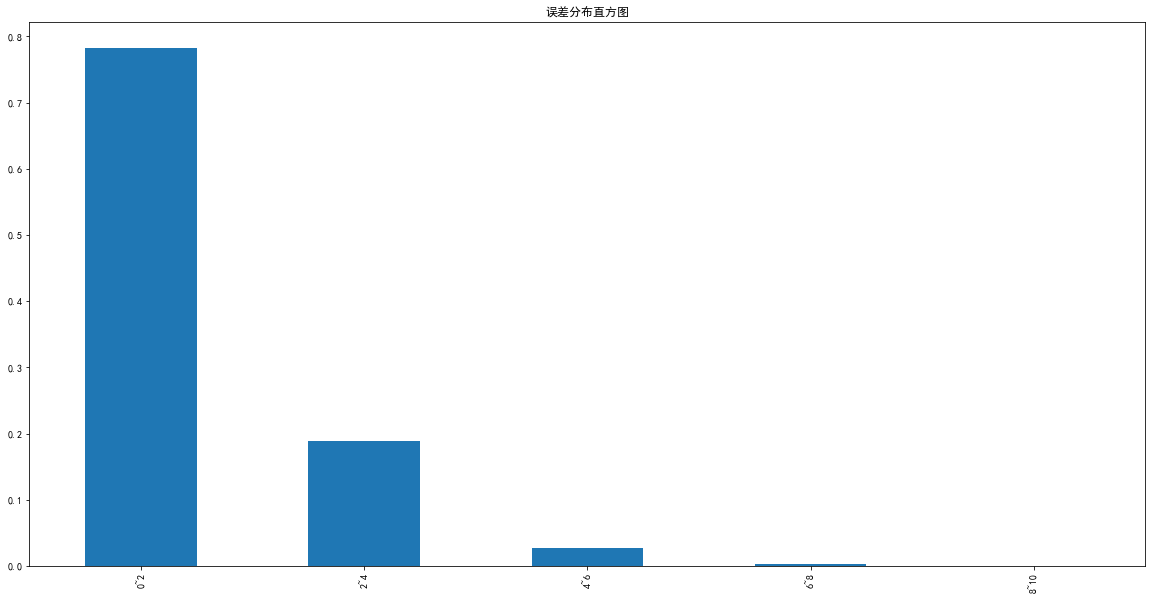

In [75]:
point_bar(df_revised.bias)

In [76]:
df_max.shape

(89, 7)

{'0~2': 0.8047752808988764, '2~4': 0.16573033707865167, '4~6': 0.026685393258426966, '6~8': 0.0028089887640449437, '8~10': 0.0}


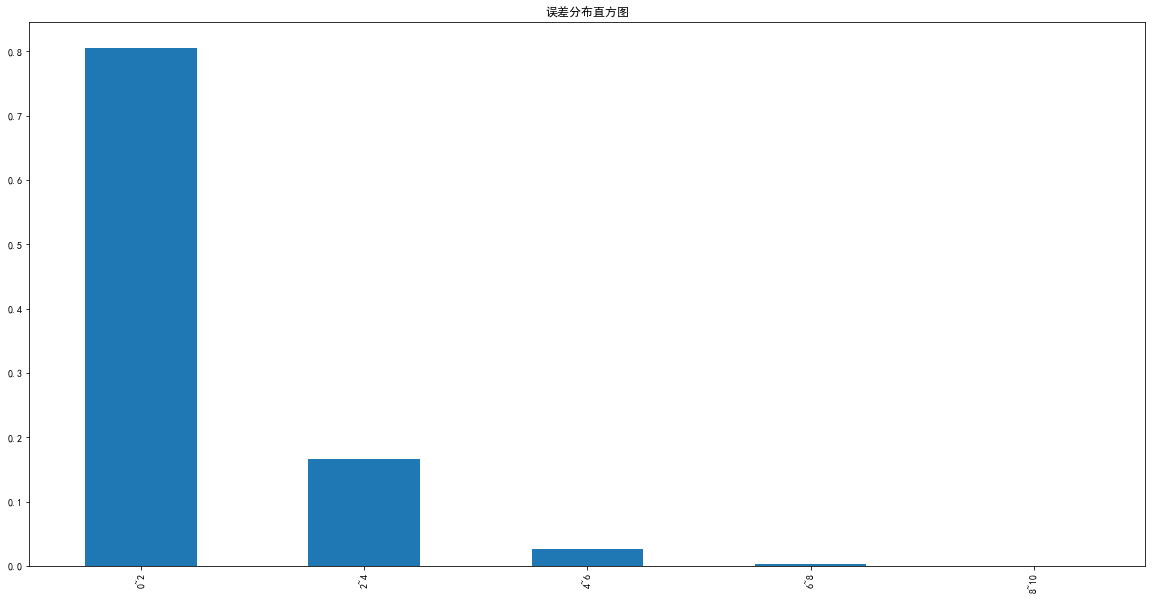

In [77]:
point_bar(df_revised.revised_bias)

{'0~2': 0.7823033707865169, '2~4': 0.18820224719101122, '4~6': 0.026685393258426966, '6~8': 0.0028089887640449437, '8~10': 0.0}


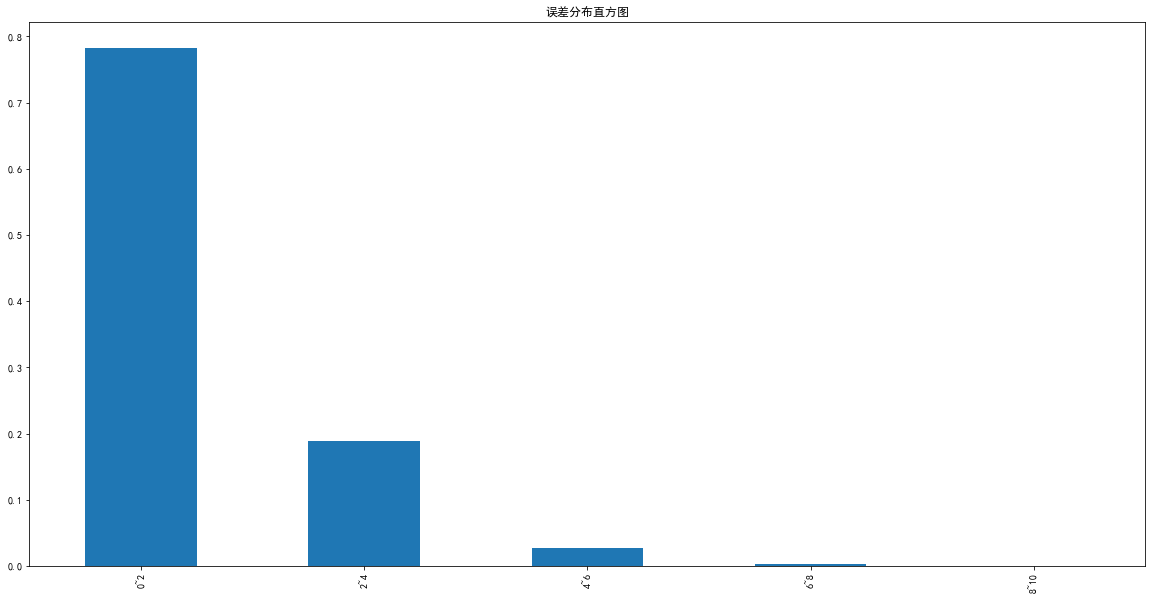

In [78]:
point_bar(df_revised.bias)

In [82]:
df_maximum = pd.concat((df_max,df_min))


In [83]:
df_maximum = df_maximum.sort_values(by='index')

In [84]:
df_maximum = df_maximum.set_index('index')

In [85]:
df_maximum.shape

(178, 7)

1.4132618401827437

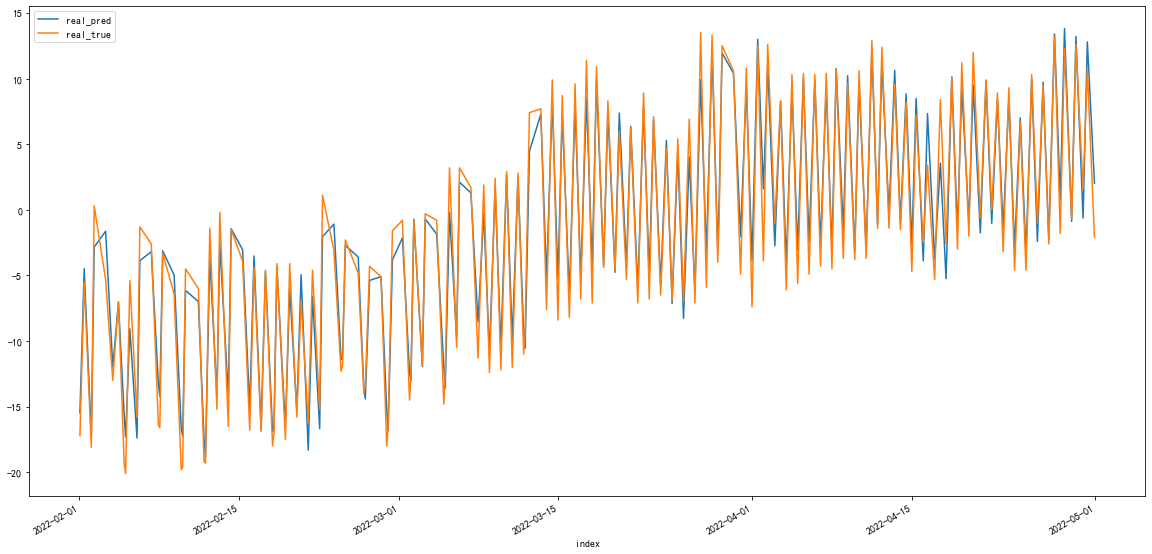

In [90]:

df_maximum[['real_pred','real_true']][:].plot(figsize=(20,10))
np.mean(np.abs(df_maximum['real_pred']-df_maximum['real_true']))

1.1214450410959687

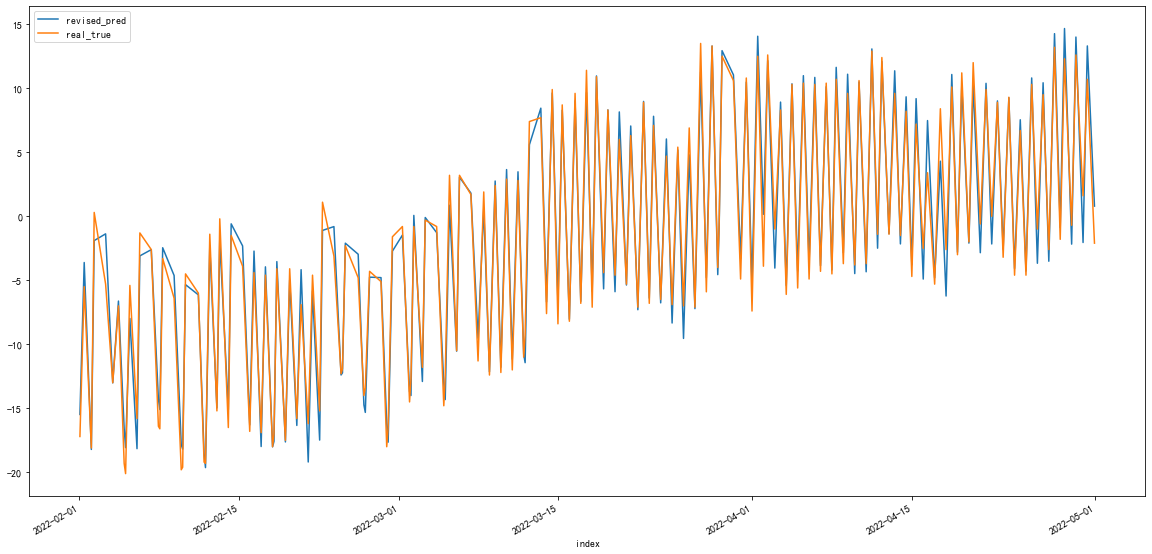

In [91]:
df_maximum[['revised_pred','real_true']][:].plot(figsize=(20,10))
np.mean(np.abs(df_maximum['revised_pred']-df_maximum['real_true']))

In [92]:
df_maximum['bias'] = np.abs(df_maximum['revised_pred']-df_maximum['real_true'])

{'0~2': 0.8202247191011236, '2~4': 0.16292134831460675, '4~6': 0.016853932584269662, '6~8': 0.0, '8~10': 0.0}


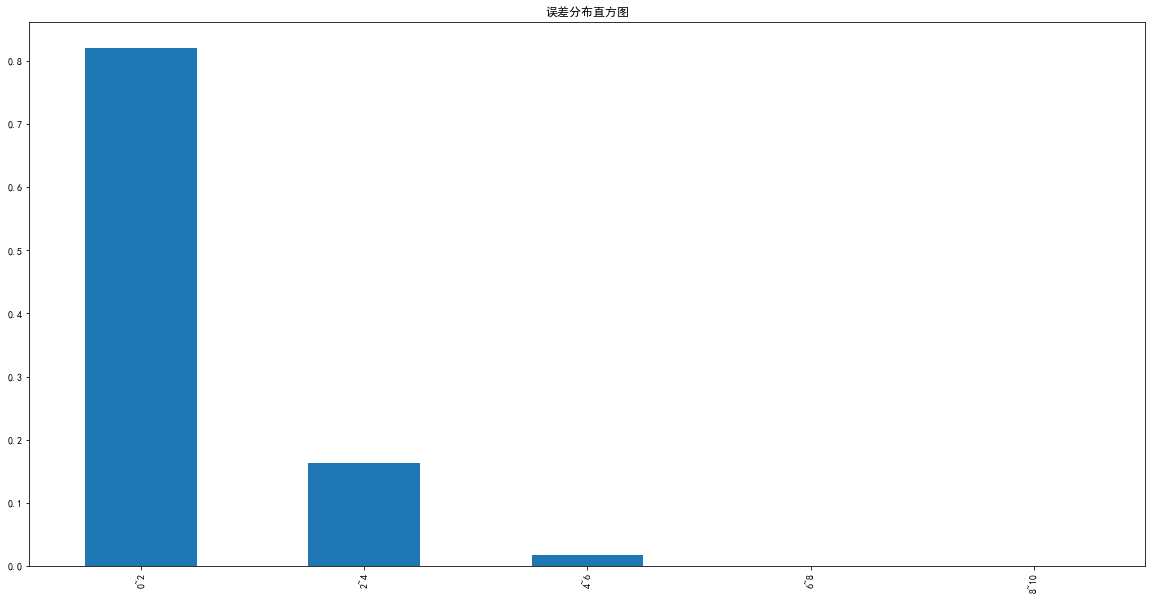

In [93]:
point_bar(df_maximum.bias)

### null值分布

In [50]:
# import numpy as np
# import pandas as pd

# df_null = pd.read_csv('../../data/informer/null_2020_2022.csv')


# df_null.is_null = df_null.is_null*1

# df_null.date = df_null.date.apply(lambda x:pd.to_datetime(x).strftime('%m'))
# # df_null = df_null.set_index('date')

# df_null = df_null.sort_values(by='date')

# df_null.date.value_counts()


# df_null.date.value_counts().plot(kind='bar',figsize=(20,10),title='误差分布直方图')

# df_null.plot()

# # real_true[24:].shape
# df